In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import math
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from scipy.stats import pearsonr

import xarray as xr
from matplotlib.pyplot import MultipleLocator
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter

file_vwnd = '../dataset/V_WIND.nc'
file_uwnd = '../dataset/U_WIND.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)
# vwnd(time, level, lat, lon) current shape = (904, 17, 73, 144)
vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']



/home/lk/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/lk/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/lk/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# eta 等于绝对涡度 rv
# 求level在850处的涡度
# |delta v / |delta x - |delta u / |delta y
# 因为纬度lat有地球偏差 x = x * cos(lat) * 111
# 每一年计算一个涡度，每个点在时间序列上有40个涡度值
# 对每个点进行相关计算
vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]
# 计算相邻两点之间的绝对距离 lat纬度 lon经度
lat = vlat[:].data
Y_derivative = abs((lat[2]-lat[0])*111)
lon = vlon[:].data
X_derivative = (lon[2]-lon[0])*111

# 计算涡度需要上面那个点 因此上下都多一行
# vwind_mid = vwnd[:1,2:3,18:55,:].data[0][0] 
vwind_mid = vwnd[:1,2:3,17:56,:].data[0][0] 
uwind_mid = uwnd[:1,2:3,17:56,:].data[0][0] 

def X_vorticity(vwind_mid):
    # 计算每个点的涡度 X_vorticity = dv / dx
    X_vorticity = np.zeros((37,144), dtype=float, order='C')
    # 从第1行计算到倒数第二行的涡度
    for row in range(1, vwind_mid.shape[0]-1):
        # 在row行的风数值
        vwind_lat = vwind_mid[row]
        # row行的lat纬度值
#         row_lat = lat[row+17]
    #     print(row, row+17)
#         X_dis = X_derivative*math.cos(math.radians(lat[row-1]))
        X_dis = X_derivative
        for i in range(len(vwind_lat)):
            if i<=len(vwind_lat)-2:
                X_vorticity[row-1][i] = (vwind_lat[i+1]-vwind_lat[i-1])/X_dis
            elif i == len(vwind_lat)-1:
                X_vorticity[row-1][i] = (vwind_lat[len(vwind_lat)-i]-vwind_lat[i-1])/X_dis
    return X_vorticity

def Y_vorticity(uwind_lat):
    # 计算 Y_vorticity = du/dy
    # 对于第一行的涡度，用第三行减去第一行，除以距离
    Y_vorticity = np.zeros((37,144), dtype=float, order='C')
    for i in range(1, 38):
        Y_vorticity[i-1] = (uwind_lat[i]-uwind_lat[i-2])/Y_derivative
    return Y_vorticity

def vorticity_mean(startYear, endYear):
    num_year = endYear-startYear
    vorticity_mean = np.zeros((num_year,37,144), dtype=float, order='C')
    for year in range(startYear, endYear):
        start, end = num_month_12toNext4(year)
        vort_tmp = vorticity_year(start, end)
#         print(vort_tmp)
        index = year - startYear
#         print(index)
        vorticity_mean[index:index+1,:,:] = vort_tmp
    return vorticity_mean

def vorticity_year(start, end):
    # start开始月份 end结束月分，num_month
    num_month = int(end-start)
    tmp_vorticity_year = np.zeros((37,144), dtype=float, order='C')
    for i in range(start, end):
        vwind_mid_tmp = vwnd[i:i+1,2:3,17:56,:].data[0][0]
        X_vorticity_tmp = X_vorticity(vwind_mid_tmp)  
        uwind_mid_tmp = uwnd[i:i+1,2:3,17:56,:].data[0][0] 
        Y_vorticity_tmp = Y_vorticity(uwind_mid_tmp)
        vorticity_tmp = X_vorticity_tmp - Y_vorticity_tmp
        tmp_vorticity_year += vorticity_tmp
    vorticity_mean = tmp_vorticity_year / num_month
    return vorticity_mean

# eta_1980to1999 = vorticity_year(384, 624)
# eta_2000to2022 = vorticity_year(624, 899)

num_month = int(624-384)
tmp_vorticity = np.zeros((37,144), dtype=float, order='C')
tmp_vorticity_year = np.zeros((20, 37, 144), dtype=float, order='C')
for month in range(384, 624, 12):
    for i in range(12):
        vwind_mid_tmp = vwnd[i:i+1,2:3,17:56,:].data[0][0]
        X_vorticity_tmp = X_vorticity(vwind_mid_tmp)  
        uwind_mid_tmp = uwnd[i:i+1,2:3,17:56,:].data[0][0] 
        Y_vorticity_tmp = Y_vorticity(uwind_mid_tmp)
        vorticity_tmp = X_vorticity_tmp - Y_vorticity_tmp
        tmp_vorticity += vorticity_tmp
    index = int((month-384)/12)
#     print(index, tmp_vorticity.shape)
    tmp_vorticity_year[index] = tmp_vorticity / 12
eta_1980to1999 = tmp_vorticity_year
# eta_1980to1999 = np.zeros((37,144), dtype=float, order='C')
# tmp = eta_1980to1999
# for i in range(20):
#     tmp += tmp_vorticity_year[i]
# eta_1980to1999 = tmp/20

num_month = int(900-624)
tmp_vorticity = np.zeros((37,144), dtype=float, order='C')
tmp_vorticity_year = np.zeros((23, 37, 144), dtype=float, order='C')
for month in range(624, 900, 12):
    for i in range(12):
        vwind_mid_tmp = vwnd[i:i+1,2:3,17:56,:].data[0][0]
        X_vorticity_tmp = X_vorticity(vwind_mid_tmp)  
        uwind_mid_tmp = uwnd[i:i+1,2:3,17:56,:].data[0][0] 
        Y_vorticity_tmp = Y_vorticity(uwind_mid_tmp)
        vorticity_tmp = X_vorticity_tmp - Y_vorticity_tmp
        tmp_vorticity += vorticity_tmp
    index = int((month-624)/12)
#     print(index, tmp_vorticity.shape)
    tmp_vorticity_year[index] = tmp_vorticity / 12
eta_2000to2022 = tmp_vorticity_year

# eta_2000to2022 = np.zeros((37,144), dtype=float, order='C')
# tmp = eta_2000to2022
# for i in range(23):
#     tmp += tmp_vorticity_year[i]
# eta_2000to2022 = tmp/23

In [10]:
dataset_vwnd['level'][2:3]

masked_array(data=[850.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [5]:
# 计算RH
dataset_rh = nc.Dataset('../dataset/xiangduishidu.nc')
# print(dataset.variables.keys())

longitude, latitude = dataset_rh.variables['lon'],dataset_rh.variables['lat']
# time = dataset.variables['time']
# level =dataset.variables['level']
rhum = dataset_rh.variables['rhum']

def rh_mean(rhum, begin_month, end_month):
    """
    rh: 计算的图表，begin_month：开始月份 num_month：每个阶段的月数
    """
    sum_month = np.zeros(rhum[:1,3:4].data[0][:,:].shape, dtype=float, order='C')  # 创建空矩阵
    sum_month_tmp = sum_month
    mean = sum_month
    for month in range(begin_month, end_month, 12):
        for i in range(12):
            tmp = month + i
            temp_pre = rhum[tmp:tmp+1,3:4].data[0][:,:]
    #     ls_first.append(sst[i:i+1].data[0][:1,-1:])
            sum_month_tmp += temp_pre
        mean = sum_month_tmp / 12
        
    return mean

rh_1980to1999 = np.zeros((20, 73, 144), dtype=float, order='C')
sum_month_tmp = np.zeros((73, 144), dtype=float, order='C')  # 创建空矩阵

for month in range(384, 624, 12):
    sum_month_tmp = np.zeros((73, 144), dtype=float, order='C')  # 创建空矩阵
    tmp = 0
    for i in range(12):
        tmp = month + i
        sum_month = rhum[tmp:tmp+1,3:4].data[0][:,:]
#     ls_first.append(sst[i:i+1].data[0][:1,-1:])
        sum_month_tmp += np.squeeze(sum_month)
    index = int((month-624)/12)
    rh_1980to1999[index] = sum_month_tmp / 12

rh_2000to2022 = np.zeros((23, 73, 144), dtype=float, order='C')
sum_month_tmp = np.zeros((73, 144), dtype=float, order='C')  # 创建空矩阵
mean = sum_month
for month in range(624, 900, 12):
    sum_month_tmp = np.zeros((73, 144), dtype=float, order='C')  # 创建空矩阵
    for i in range(12):
        tmp = month + i
        sum_month = rhum[tmp:tmp+1,3:4].data[0][:,:]
#     ls_first.append(sst[i:i+1].data[0][:1,-1:])
        sum_month_tmp += np.squeeze(sum_month)
    index = int((month-624)/12)
    rh_2000to2022[index] = sum_month_tmp / 12

In [156]:
rhum[:1,3:4].data[0][:,:]

array([[[71.229996, 71.229996, 71.229996, ..., 71.229996, 71.229996,
         71.229996],
        [56.710007, 55.839996, 55.089996, ..., 59.460007, 58.539993,
         57.660004],
        [57.800003, 58.910004, 60.069992, ..., 55.369995, 56.03    ,
         56.819992],
        ...,
        [80.97    , 84.36    , 87.11    , ..., 68.520004, 73.19    ,
         77.17999 ],
        [80.89    , 81.5     , 82.      , ..., 77.75    , 78.95999 ,
         80.05    ],
        [79.42    , 79.42    , 79.42    , ..., 79.42    , 79.42    ,
         79.42    ]]], dtype=float32)

In [157]:
2.5e+06

2500000.0

In [6]:
file_daqiwendu = '../dataset/daqiwendu.nc'
file_jueduishidu = '../dataset/jueduishidu.nc'
file_haiyangbiaomian = '../dataset/sst.nc' 
file_xiangduishidu = '../dataset/xiangduishidu.nc'
file_weishigaodu = '../dataset/weishigaodu.nc'

dataset_daqiwendu = nc.Dataset(file_daqiwendu)
dataset_jueduishidu = nc.Dataset(file_jueduishidu)
dataset_haiyangbiaomian = nc.Dataset(file_haiyangbiaomian)
dataset_xiangduishidu = nc.Dataset(file_xiangduishidu)
dataset_weishigaodu = nc.Dataset(file_weishigaodu)

DaQiWenDu = dataset_daqiwendu['air']
DaQiWenDu_level_200 = DaQiWenDu[:,9:10,:,:]
DaQiWenDu_level_1000 = DaQiWenDu[:,:1,:,:]
HaiYangBiaoMian = dataset_haiyangbiaomian['sst']

# 绝对湿度To 的1980to1999 level 300 1980-1999
JueDuiShiDu_To_1980to1999 = dataset_jueduishidu['shum'][384:624,7:]
# 绝对湿度Ts 的2000to2022 level 1000 1980-1999
JueDuiShiDu_Ts_1980to1999 = dataset_jueduishidu['shum'][384:624,:1]
# 绝对湿度To 的2000to2022 level 300 2000-2022
JueDuiShiDu_To_2000to2022 = dataset_jueduishidu['shum'][624:900,7:]
# 绝对湿度Ts 的2000to2022 level 1000 2000-2022
JueDuiShiDu_Ts_2000to2022 = dataset_jueduishidu['shum'][624:900,:1]

# 相对湿度To 的1980to1999 level 300 1980-1999
XiangDuiShiDu_To_1980to1999 = dataset_xiangduishidu['rhum'][384:624,7:]
# 相对湿度Ts 的1980to1999 level 1000 1980-1999
XiangDuiShiDu_Ts_1980to1999 = dataset_xiangduishidu['rhum'][384:624,:1]
# 相对湿度To 的2000to2022 level 300 2000-2022
XiangDuiShiDu_To_2000to2022 = dataset_xiangduishidu['rhum'][624:900,7:]
# 相对湿度Ts 的2000to2022 level 1000 2000-2022
XiangDuiShiDu_Ts_2000to2022 = dataset_xiangduishidu['rhum'][624:900,:1]

# 位势高度To 的1980to1999 level 200 1980-1999
WeiShiGaoDu_To_1980to1999 = dataset_weishigaodu['hgt'][384:624,9:10]
# 位势高度Ts 的1980to1999 level 1000 1980-1999
WeiShiGaoDu_Ts_1980to1999 = dataset_weishigaodu['hgt'][384:624,:1]
# 位势高度To 的2000to2022 level 200 2000-2022
WeiShiGaoDu_To_2000to2022 = dataset_weishigaodu['hgt'][624:900,9:10]
# 位势高度Ts 的2000to2022 level 1000 2000-2022
WeiShiGaoDu_Ts_2000to2022 = dataset_weishigaodu['hgt'][624:900,:1]

# 大气温度To 的1980to1999 level 200 1980-1999
DaQiWenDu_To_1980to1999 = dataset_daqiwendu['air'][384:624,9:10]
# 大气温度Ts 的1980to1999 level 1000 1980-1999
DaQiWenDu_Ts_1980to1999 = dataset_daqiwendu['air'][384:624,:1]
# 大气温度To 的2000to2022 level 200 2000-2022
DaQiWenDu_To_2000to2022 = dataset_daqiwendu['air'][624:900,9:10]
# 大气温度Ts 的2000to2022 level 1000 2000-2022
DaQiWenDu_Ts_2000to2022 = dataset_daqiwendu['air'][624:900,:1]


def year_mean(year_num, df_):
    '''
    计算每一个阶段的年数，year_num
    df_ 需要计算的表格
    '''
    zero_lat_lon = np.zeros((73,144), dtype=float, order='C') 
    zero_lat_lon_year = np.zeros([year_num,73,144], dtype=float, order='C')
    df_ = np.squeeze(df_)
    
    for year in range(year_num):
        tmp = np.zeros([1,73,144], dtype=float, order='C')
        # 对每月的air进行求和
        month_mean = np.zeros((73,144), dtype=float, order='C')
        # 设置DaQiWenDu_year的索引
        for i in range(12):
            tmp += df_[i+year*12:i+1+year*12]
        # 计算月平均
        month_mean = tmp / 12
        zero_lat_lon_year[year] = month_mean
    return zero_lat_lon_year

JueDuiShiDu_To_1980to1999_mean = year_mean(20, JueDuiShiDu_To_1980to1999)
XiangDuiShiDu_To_1980to1999_mean = year_mean(20, XiangDuiShiDu_To_1980to1999)
WeiShiGaoDu_To_1980to1999_mean = year_mean(20, WeiShiGaoDu_To_1980to1999)
DaQiWenDu_To_1980to1999_mean = year_mean(20, DaQiWenDu_To_1980to1999)

JueDuiShiDu_Ts_1980to1999_mean = year_mean(20, JueDuiShiDu_Ts_1980to1999)
XiangDuiShiDu_Ts_1980to1999_mean = year_mean(20, XiangDuiShiDu_Ts_1980to1999)
WeiShiGaoDu_Ts_1980to1999_mean = year_mean(20, WeiShiGaoDu_Ts_1980to1999)
DaQiWenDu_Ts_1980to1999_mean = year_mean(20, DaQiWenDu_Ts_1980to1999)

J_div_X = np.zeros((73,144), dtype=float, order='C')
J_div_X_1980to1999_lev200 = np.zeros((20,73,144), dtype=float, order='C')
for i in range(20):
    tmp2d_j = JueDuiShiDu_To_1980to1999_mean[i:i+1][0]
    tmp2d_x = XiangDuiShiDu_To_1980to1999_mean[i:i+1][0]
    for x in range(73):
        for y in range(144):
            tmp_div = tmp2d_j[x][y] / tmp2d_x[x][y]
            J_div_X[x][y] = tmp_div
    J_div_X_1980to1999_lev200[i] = J_div_X
    
ho_1980to1999_lev200 = 1.005 * DaQiWenDu_To_1980to1999_mean + J_div_X_1980to1999_lev200 * 2500000 + 9.8 * WeiShiGaoDu_To_1980to1999_mean

# 计算1980to1999 hs值 1980-1999 1000 level
J_div_X = np.zeros((73,144), dtype=float, order='C')
J_div_X_1980to1999_lev1000 = np.zeros((20,73,144), dtype=float, order='C')
for i in range(20):
    tmp2d_j = JueDuiShiDu_Ts_1980to1999_mean[i:i+1][0]
    tmp2d_x = XiangDuiShiDu_Ts_1980to1999_mean[i:i+1][0]
    for x in range(73):
        for y in range(144):
            tmp_div = tmp2d_j[x][y] / tmp2d_x[x][y]
            J_div_X[x][y] = tmp_div
    J_div_X_1980to1999_lev1000[i] = J_div_X
    
hs_1980to1999_lev1000 = 1.005 * DaQiWenDu_Ts_1980to1999_mean + J_div_X_1980to1999_lev1000 * 2500000 + 9.8 * WeiShiGaoDu_Ts_1980to1999_mean

ts_div_to = np.zeros((73,144), dtype=float, order='C')
ts_div_to_1980to1999 = np.zeros((20,73,144), dtype=float, order='C')
for i in range(20):
    tmp2d_ts = DaQiWenDu_Ts_1980to1999_mean[i:i+1][0]
    tmp2d_to = DaQiWenDu_To_1980to1999_mean[i:i+1][0]
    for x in range(73):
        for y in range(144):
            tmp_div = tmp2d_ts[x][y] / tmp2d_to[x][y]
            ts_div_to[x][y] = tmp_div
    ts_div_to_1980to1999[i] = ts_div_to
Vmax_1980to1999 = 0.9 *(ts_div_to_1980to1999 - 1)*(hs_1980to1999_lev1000-ho_1980to1999_lev200) 


# 计算第二阶段的Vmax
JueDuiShiDu_To_2000to2022_mean = year_mean(23, JueDuiShiDu_To_2000to2022)
XiangDuiShiDu_To_2000to2022_mean = year_mean(23, XiangDuiShiDu_To_2000to2022)
WeiShiGaoDu_To_2000to2022_mean = year_mean(23, WeiShiGaoDu_To_2000to2022)
DaQiWenDu_To_2000to2022_mean = year_mean(23, DaQiWenDu_To_2000to2022)

JueDuiShiDu_Ts_2000to2022_mean = year_mean(23, JueDuiShiDu_Ts_2000to2022)
XiangDuiShiDu_Ts_2000to2022_mean = year_mean(23, XiangDuiShiDu_Ts_2000to2022)
WeiShiGaoDu_Ts_2000to2022_mean = year_mean(23, WeiShiGaoDu_Ts_2000to2022)
DaQiWenDu_Ts_2000to2022_mean = year_mean(23, DaQiWenDu_Ts_2000to2022)

# h = 1.013*DaQiWenDu + JueDuiShiDu/XiangDuiShiDu*44 + 9.8*WeiShiGaoDu
# 计算2000to2022 ho值 2000-2022 200 level
J_div_X = np.zeros((73,144), dtype=float, order='C')
J_div_X_2000to2022_lev200 = np.zeros((23,73,144), dtype=float, order='C')
for i in range(23):
    tmp2d_j = JueDuiShiDu_To_2000to2022_mean[i:i+1][0]
    tmp2d_x = XiangDuiShiDu_To_2000to2022_mean[i:i+1][0]
    for x in range(73):
        for y in range(144):
            tmp_div = tmp2d_j[x][y] / tmp2d_x[x][y]
            J_div_X[x][y] = tmp_div
    J_div_X_2000to2022_lev200[i] = J_div_X
    
ho_2000to2022_lev200 = 1.005 * DaQiWenDu_To_2000to2022_mean + J_div_X_2000to2022_lev200 * 1002 + 9.8 * WeiShiGaoDu_To_2000to2022_mean

# 计算2000to2022 hs值 2000-2022 1000 level
J_div_X = np.zeros((73,144), dtype=float, order='C')
J_div_X_2000to2022_lev1000 = np.zeros((23,73,144), dtype=float, order='C')
for i in range(23):
    tmp2d_j = JueDuiShiDu_Ts_2000to2022_mean[i:i+1][0]
    tmp2d_x = XiangDuiShiDu_Ts_2000to2022_mean[i:i+1][0]
    for x in range(73):
        for y in range(144):
            tmp_div = tmp2d_j[x][y] / tmp2d_x[x][y]
            J_div_X[x][y] = tmp_div
    J_div_X_2000to2022_lev1000[i] = J_div_X
    
hs_2000to2022_lev1000 = 1.005 * DaQiWenDu_Ts_2000to2022_mean + J_div_X_2000to2022_lev1000 * 1002 + 9.8 * WeiShiGaoDu_Ts_2000to2022_mean

ts_div_to = np.zeros((73,144), dtype=float, order='C')
ts_div_to_2000to2022 = np.zeros((23,73,144), dtype=float, order='C')
for i in range(23):
    tmp2d_ts = DaQiWenDu_Ts_2000to2022_mean[i:i+1][0]
    tmp2d_to = DaQiWenDu_To_2000to2022_mean[i:i+1][0]
    for x in range(73):
        for y in range(144):
            tmp_div = tmp2d_ts[x][y] / tmp2d_to[x][y]
            ts_div_to[x][y] = tmp_div
    ts_div_to_2000to2022[i] = ts_div_to

Vmax_2000to2022 = 0.9 *(ts_div_to_2000to2022 - 1)*(hs_2000to2022_lev1000-ho_2000to2022_lev200)


In [7]:
print(JueDuiShiDu_To_1980to1999_mean.max(), JueDuiShiDu_To_1980to1999_mean.min())
print(XiangDuiShiDu_To_1980to1999_mean.max(), XiangDuiShiDu_To_1980to1999_mean.min())
print(WeiShiGaoDu_To_1980to1999_mean.max(), WeiShiGaoDu_To_1980to1999_mean.min())
print(DaQiWenDu_To_1980to1999_mean.max(), DaQiWenDu_To_1980to1999_mean.min())

0.8481659889221191 8.328755696614583e-05
77.85583241780598 0.01000213623046875
12495.345784505209 10698.542724609375
-46.962493896484375 -65.26499303181966


In [8]:
# 计算Vs VWS

vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
vlevel_200 = vwnd[:1,9:10].data[0][:,:][0]

ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]
ulevel_200 = uwnd[:1,9:10].data[0][:,:][0]

def diff_square(a, b):
    # 求两相同大小的矩阵个元素之间的平方和
    _square = np.zeros(vlevel_850.shape, dtype=float, order='C')
    for i in range(len(a)):
        for j in range(len(a[0])):
            tmp = (a[i][j] - b[i][j])**2
            _square[i][j] = tmp
    return _square

def diff_sqrt(v_200, v_850, u_200, u_850):
    # 求矩阵个元素的开放
    vlevel_sqrt = np.zeros(vlevel_850.shape, dtype=float, order='C') 
    vlevel_square = diff_square(v_200, v_850)
    ulevel_square = diff_square(u_200, u_850)

    for i in range(len(vlevel_square)):
        for j in range(len(vlevel_square[i])):
            tmp = vlevel_square[i][j] + ulevel_square[i][j]
            vlevel_sqrt[i][j] = sqrt(tmp)
    return vlevel_sqrt
        
def num_month(a):
    '''
    计算循环的起始年，结束年
    '''
    if a == 1982:
        num_months = (1982 - 1948 + 1) * 12 
        num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
        start = num_months
        end = start + num_month_1997to1982
    elif a == 1998:
        start = (1998 - 1948 + 1) * 12 + 1
        num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数
        end = start + num_month_2021to1998
    else:
        print("Input must be 1982 or 1998!")
    return start, end

# 循环时间
def sum_year(start, end, vwnd, uwnd):
    '''
    计算平均值
    '''
    sum_months = np.zeros(vwnd[:1,0:1].data[0][:,:].shape, dtype=float, order='C')
    for i in range(start, end): 
        tmp_vlevel_850 = vwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_vlevel_200 = vwnd[i:i+1,9:10].data[0][:,:][0]
        tmp_ulevel_850 = uwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_ulevel_200 = uwnd[i:i+1,9:10].data[0][:,:][0]
        tmp_vwp = diff_sqrt(tmp_vlevel_200, tmp_vlevel_850, tmp_ulevel_200, tmp_ulevel_850)
        sum_months += tmp_vwp
    return sum_months


vws_1980to1999 = np.zeros((20, 73, 144), dtype=float, order='C')
for month in range(384, 624, 12):
    tmp = sum_year(month, month+12, vwnd, uwnd)/12
    index = int((month-384)/12)
    vws_1980to1999[index] = tmp
    
vws_2000to2022 = np.zeros((23, 73, 144), dtype=float, order='C')
for month in range(624, 900, 12):
    tmp = sum_year(month, month+12, vwnd, uwnd)/12
    index = int((month-624)/12)
    vws_2000to2022[index] = tmp   

In [9]:
# 计算 omega

dataset_omega = nc.Dataset('../dataset/omega.mon.mean.nc')

omega_phase1 = np.squeeze(dataset_omega['omega'][384:624,5:6,:,:])
omega_phase2 = np.squeeze(dataset_omega['omega'][624:900,5:6,:,:])

omega_1980to1999 = np.zeros((20, 73, 144), dtype=float, order='C')
zero_month = np.zeros((73, 144), dtype=float, order='C')
for month in range(0, 624-384, 12):
    for i in range(12):
        zero_month += omega_phase1[month+i]
    index = int(month/12)
    omega_1980to1999[index] = zero_month/12
    
omega_2000to2022 = np.zeros((23, 73, 144), dtype=float, order='C')
for month in range(0, 900-624, 12):
    for i in range(12):
        zero_month += omega_phase2[month+i]
    index = int(month/12)
    omega_2000to2022[index] = zero_month/12


In [10]:
print("eta的最大最小值是",eta_1980to1999.max(), eta_2000to2022.max())
print("rh的最大最小值是",rh_1980to1999.max(), rh_2000to2022.max())
print("Vmax的最大最小值是",Vmax_1980to1999.max(), Vmax_2000to2022.max())
print("vws的最大最小值是",vws_1980to1999.max(), vws_2000to2022.max())
print("omega的最大最小值是",omega_1980to1999.max(), omega_2000to2022.max())

eta的最大最小值是 0.5305403949211804 0.6101214541593576
rh的最大最小值是 98.82666524251302 99.12583033243816
Vmax的最大最小值是 49186.507179645654 180258.06707327208
vws的最大最小值是 44.36881669186945 45.91276121616564
omega的最大最小值是 1.811376730600993 3.8712276572380993


In [155]:
2 ** -2

0.25

In [11]:
# 计算每年的gpi lat的数据来自于17:56
# eta_1980to1999, eta_2000to2022 (37, 144)
# rh_1980to1999, rh_2000to2022   (73, 144)
# Vmax_1980to1999, Vmax_2000to2022   (73, 144)
# vws_1980to1999, vws_2000to2022   (73, 144)
# omega_1980to1999, omega_2000to2022   (73, 144)
# def gpi(a, b, d, e):
def gpi(a, b, c, d, e):
    tmp_a= abs(a * 100000) ** 1.5
    tmp_b = (b / 50) ** 3
    tmp_c = (c / 70) ** 3
    tmp_d = (1 + 0.1 * d) ** -2
    tmp_e = -10 * e + 1
#     return tmp_a * tmp_b * tmp_d * tmp_e
    return tmp_a * tmp_b * tmp_c * tmp_d * tmp_e



zero_gpi_1 = np.zeros((20, 37, 144), dtype=float, order='C')
zero_tmp_1 = np.zeros((37, 144), dtype=float, order='C')
for year in range(20):
    eta = eta_1980to1999[year]
    rh = rh_1980to1999[year]
    Vmax = Vmax_1980to1999[year]
    vws = vws_1980to1999[year]
    omega = omega_1980to1999[year]
    for lat in range(18, 55):
        for lon in range(0, 143):
            zero_tmp_1[lat-18][lon] = gpi(eta[lat-18][lon], 
                                        rh[lat][lon],
                                        Vmax[lat][lon],
                                        vws[lat][lon],
                                        omega[lat][lon])
    zero_gpi_1[year] = zero_tmp_1
    
gpi_mean_1980to1999 = np.zeros((37, 144), dtype=float, order='C')
zero_tmp_mean_1 = np.zeros((37, 144), dtype=float, order='C')
for month in range(20):
    zero_tmp_mean_1 += zero_gpi_1[month]
gpi_mean_1980to1999 = zero_tmp_mean_1/20

    
zero_gpi_2 = np.zeros((23, 37, 144), dtype=float, order='C')
zero_tmp_2 = np.zeros((37, 144), dtype=float, order='C')
for year in range(23):
    eta = eta_2000to2022[year]
    rh = rh_2000to2022[year]
    Vmax = Vmax_2000to2022[year]
    vws = vws_2000to2022[year]
    omega = omega_2000to2022[year]
    for lat in range(18, 55):
        for lon in range(0, 143):
            zero_tmp_2[lat-18][lon] = gpi(eta[lat-18][lon], 
                                        rh[lat][lon],
                                        Vmax[lat][lon],
                                        vws[lat][lon],
                                        omega[lat][lon])
    zero_gpi_2[year] = zero_tmp_2
    
gpi_mean_2000to2022 = np.zeros((37, 144), dtype=float, order='C')
zero_tmp_mean_2 = np.zeros((37, 144), dtype=float, order='C')

for month in range(23):
    zero_tmp_mean_2 += zero_gpi_2[month]
gpi_mean_2000to2022 = zero_tmp_mean_2/23
    
    
diff = gpi_mean_2000to2022 - gpi_mean_1980to1999


print(diff.max() , diff.min())

7.495704135828622e+18 -2.497175717148358e+18


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


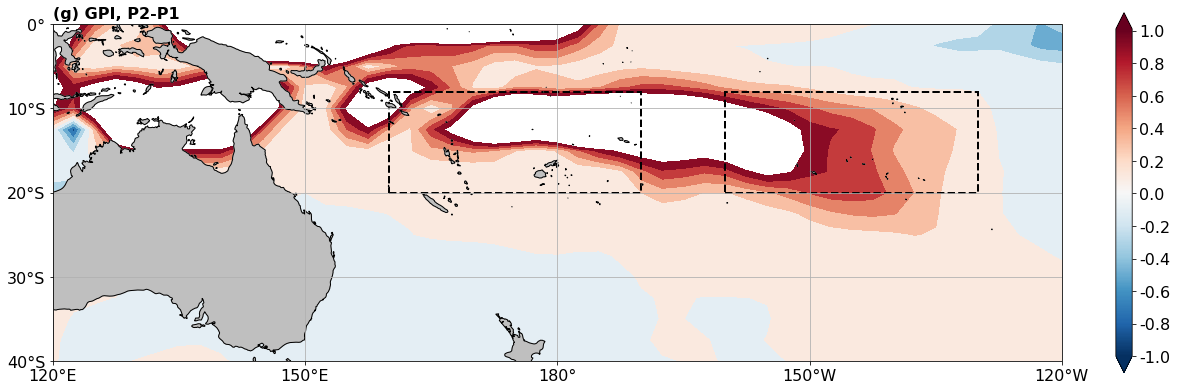

In [12]:
from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from matplotlib import rcParams
from matplotlib import patches

longitude, latitude = dataset_vwnd.variables['lon'],dataset_vwnd.variables['lat']


# 设置字体
config = {
    "font.family": 'Times New Roman',
    "font.size": 16,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 1 + 0.01
MIN = -1
INTER = 0.2
# 设置经纬度
lon = vlon[:].data
lat = vlat[19:56].data
# # 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
# print(diff_pacific_contre.max(), diff_pacific_contre.min())


fig = plt.figure(figsize=(15,5))


proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(g) GPI, P2-P1',loc='left',fontsize =16, fontweight='bold')
# fig_ax1.contourf(lon, lat, diff, 
#                 levels=bins, 
# #                 color=['blue','red','yellow','black'],
# #                 hatches='///',
#                 transform=cartopy.crs.PlateCarree(),
#                cmap=plt.cm.RdBu_r)
cont = fig_ax1.contourf(lon, lat, diff * 1e-17, 
                 levels=np.arange(MIN, MAX, INTER),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
# fig_ax1.contourf(lon, lat, diff,levels=[0,0.05,1], zorder=1, hatches=['....',None],colors="none", transform=ccrs.PlateCarree())

# black_quarter = patches.Rectangle((146,-24),71,19,linestyle = 'dashed', 
#                                   lw=4, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
# fig_ax1.add_patch(black_quarter)

black_quarter_b1 = patches.Rectangle((160,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
black_quarter_b2 = patches.Rectangle((200,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
fig_ax1.add_patch(black_quarter_b1)
fig_ax1.add_patch(black_quarter_b2)

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

# cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-1.25,1.25,8))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::1])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',
                 ticks=np.arange(MIN, MAX, INTER).tolist(), 
#                  label='[Nas]',                       
                 extend='both', 
#                  label='$\\times 10^{10}$',
                fraction=0.0155) 

# plt.colorbar(cont,fraction=0.012)

plt.savefig("gpi_0315.png",dpi=300,bbox_inches='tight')
plt.show()

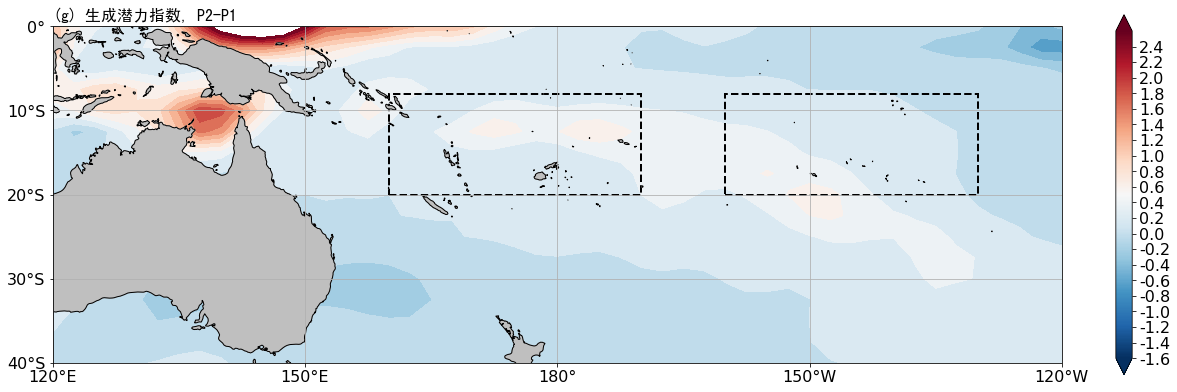

In [35]:
from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from matplotlib import rcParams
from matplotlib import patches
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

longitude, latitude = dataset_vwnd.variables['lon'],dataset_vwnd.variables['lat']


# 设置字体
config = {
    "font.family": 'Times New Roman',
    "font.size": 16,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 2.6
MIN = -1.6
INTER = 0.2
# 设置经纬度
lon = vlon[:].data
lat = vlat[19:56].data
# # 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
# print(diff_pacific_contre.max(), diff_pacific_contre.min())


fig = plt.figure(figsize=(15,5))


proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(g) 生成潜力指数, P2-P1',loc='left',
                  fontproperties='SimHei', 
                  fontsize =16, fontweight='bold')
# fig_ax1.contourf(lon, lat, diff, 
#                 levels=bins, 
# #                 color=['blue','red','yellow','black'],
# #                 hatches='///',
#                 transform=cartopy.crs.PlateCarree(),
#                cmap=plt.cm.RdBu_r)
cont = fig_ax1.contourf(lon, lat, diff * 1e-10, 
                 levels=np.arange(MIN, MAX, INTER),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
# fig_ax1.contourf(lon, lat, diff,levels=[0,0.05,1], zorder=1, hatches=['....',None],colors="none", transform=ccrs.PlateCarree())

# black_quarter = patches.Rectangle((146,-24),71,19,linestyle = 'dashed', 
#                                   lw=4, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
# fig_ax1.add_patch(black_quarter)

black_quarter_b1 = patches.Rectangle((160,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
black_quarter_b2 = patches.Rectangle((200,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
fig_ax1.add_patch(black_quarter_b1)
fig_ax1.add_patch(black_quarter_b2)

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

# cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-1.25,1.25,8))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::1])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',
                 ticks=np.arange(MIN, MAX, INTER).tolist(),     
#                  label='[Nas]',                       
                 extend='both', 
#                  label='$\\times 10^{10}$',
                fraction=0.0155) 

# plt.colorbar(cont,fraction=0.012)

plt.savefig("gpi_0315_CN.png",dpi=300,bbox_inches='tight')
plt.show()